In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


# Generate a count matrix of random noise

We want our factor model to tell us that this is just noise

In [2]:
N = 50000
D = 30
P = 3

# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': np.random.poisson(1.0, size=(N, D)),
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(10000)


Currently, the input data has to be in this format, as a tensorflow BatchDataset object with the given key/values.

# Set up the inference object

In [3]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    encoder_function=lambda x: x, decoder_function=lambda x: x,
    u_tau_scale=1.0/P/D/np.sqrt(N),
    dtype=tf.float64)
# Test to make sure sampling works


Feature dim: 30 -> Latent dim 3


## Test out the prior distributions

In [4]:
## 
sample = factor.joint_prior.sample(10)
# Compute the joint log probability of the sample
probs = factor.joint_prior.log_prob(sample)
sample_surrogate = factor.surrogate_distribution.sample(77)
probs_parts = factor.unormalized_log_prob_parts(
    **sample_surrogate, data=next(iter(data)))
prob = factor.unormalized_log_prob(
    **sample_surrogate,  data=next(iter(data)))



# Inference

In [5]:
losses = factor.calibrate_advi(
    num_epochs=25, rel_tol=1e-4, learning_rate=.1)



W0529 22:27:48.005984 4508679616 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 42.147368842701574
Epoch 1: average-batch loss: 39.29265945084791 last batch loss: 37.11271599008829
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 36.99801922312025 last batch loss: 36.32141299690546
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 36.17385464660383 last batch loss: 36.0552949698961
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 36.05759194720036 last batch loss: 36.00774869177646
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 36.08224998410399 last batch loss: 36.022549937991535
Epoch 6: average-batch loss: 36.05696069421204 last batch loss: 36.02951096194274
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 7: average-batch loss: 36.02343712628249 last batch loss: 35.97816225076085
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 8: average-batch loss: 35.99650285343886 last batch loss: 35.95956099838272
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 9: average-batch loss: 35

# Compute the WAIC

In [6]:
waic = factor.waic()
print(waic)

{'waic': 1129140.6136472907, 'se': 1210.824079238707, 'lppd': -411492.3496293957, 'pwaic': 153077.95719424964}


# Plot the factor encoding matrix

In [7]:
surrogate_samples = factor.surrogate_distribution.sample(1000)
weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)
intercept_data = az.convert_to_inference_data(
    {
        r"$w_d$": 
            (tf.squeeze(surrogate_samples['w'])*weights[:,-1,:]*factor.norm_factor).numpy().T})

In [8]:
factor.intercept_matrix()

<tf.Tensor: shape=(1, 30), dtype=float64, numpy=
array([[0.99470279, 1.00163672, 1.00463167, 0.99572344, 1.0092213 ,
        0.99875619, 0.99825622, 1.00240354, 0.9991902 , 0.99708064,
        1.00192772, 1.00391658, 1.00885572, 0.99530789, 0.99552829,
        0.9940839 , 1.00440201, 1.00187398, 1.00010661, 1.01127399,
        0.99973254, 1.00284008, 1.00680188, 1.00593121, 1.00343904,
        0.99975626, 1.00340794, 1.00575587, 1.0021072 , 1.00164345]])>

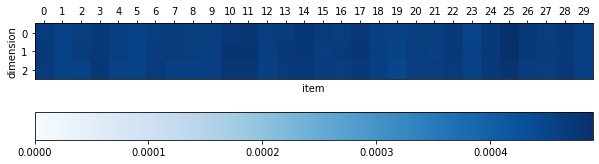

In [9]:
fig, ax = plt.subplots(figsize=(10,4))

plt.imshow(factor.encoding_matrix().numpy().T, vmin=0, cmap="Blues")
plt.xticks(np.arange(D))
ax.set_xlabel("item")
ax.set_ylabel("dimension")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.yticks(np.arange(P))
plt.colorbar(orientation = "horizontal")
plt.show()


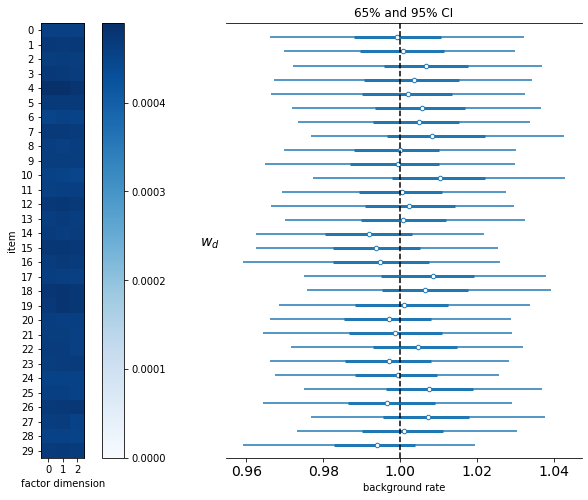

In [10]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(1.0, linestyle='dashed', color="black")
plt.savefig('noise_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()


The values in the factor encoding matrix as near zero. There is a gradient because the model induces a dimensional decay to remove symmetries - this encourages the leading dimensions to hold more of the signal.

In [11]:
factor.calibrated_expectations['s']/tf.reduce_sum(factor.calibrated_expectations['s'], axis=0, keepdims=True)

<tf.Tensor: shape=(2, 30), dtype=float64, numpy=
array([[0.09878169, 0.09769148, 0.09935982, 0.10174228, 0.1013539 ,
        0.09626229, 0.10105037, 0.09686441, 0.09711001, 0.09715991,
        0.10079694, 0.09913763, 0.09671148, 0.09694754, 0.09982884,
        0.09679655, 0.09644282, 0.09918568, 0.09785145, 0.09831894,
        0.09683988, 0.09723956, 0.10034985, 0.09798033, 0.09975369,
        0.10304015, 0.1036517 , 0.09838449, 0.09888175, 0.09752255],
       [0.90121831, 0.90230852, 0.90064018, 0.89825772, 0.8986461 ,
        0.90373771, 0.89894963, 0.90313559, 0.90288999, 0.90284009,
        0.89920306, 0.90086237, 0.90328852, 0.90305246, 0.90017116,
        0.90320345, 0.90355718, 0.90081432, 0.90214855, 0.90168106,
        0.90316012, 0.90276044, 0.89965015, 0.90201967, 0.90024631,
        0.89695985, 0.8963483 , 0.90161551, 0.90111825, 0.90247745]])>

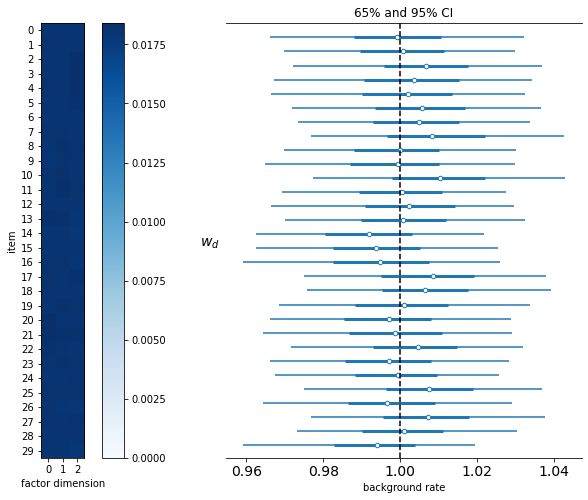

In [12]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.decoding_matrix().numpy().T[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(1.0, linestyle='dashed', color="black")
plt.show()


In [13]:
factor.decoding_matrix().numpy().shape

(3, 30)

In [14]:
factor.encoding_matrix().numpy().shape

(30, 3)

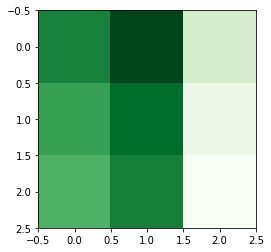

In [16]:
plt.imshow(factor.decoding_matrix().numpy().dot(factor.encoding_matrix().numpy()),cmap="Greens")